In [ ]:
! pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from scipy import stats
from statsmodels.tools.eval_measures import rmse

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Fall 2021 DSCI560/meeting1/all_level.txt") 

In [ ]:
level1 = df[df['location']=="1st Floor"].reset_index()
level2 = df[df['location']=="2nd Floor"].reset_index()
level3 = df[df['location']=="3rd Floor"].reset_index()
levelg = df[df['location']=="Ground Floor"].reset_index()

In [ ]:
# https://www.kaggle.com/wuxt830/electricity-usage-prediction-simple-time-series#2.-Seasonal-ARIMA-Model 
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=20).mean()
    rolstd = timeseries.rolling(window=20).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# ---------------------------------------------------------------------

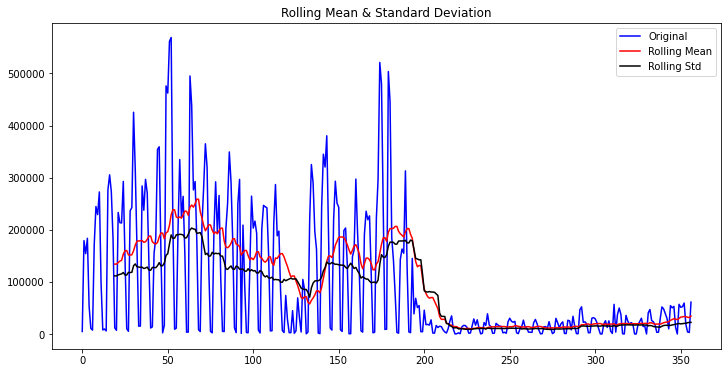

Results of Dickey-Fuller Test:
Test Statistic                  -1.840533
p-value                          0.360532
#Lags Used                      14.000000
Number of Observations Used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64


In [ ]:
test_stationarity(levelg['count'] )

In [ ]:
levelg['box_cox_count'] = stats.boxcox(levelg['count'])[0]
levelg['first_difference'] = levelg['box_cox_count'] - levelg['box_cox_count'].shift(1)   

In [ ]:
train_g, test_g = train_test_split(levelg['first_difference'].dropna(inplace=False), train_size=320)
model_g = pm.auto_arima(train_g, seasonal=True, stepwise=True)

In [ ]:
model_g.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  320
Model:               SARIMAX(4, 0, 5)   Log Likelihood                -923.238
Date:                Wed, 17 Nov 2021   AIC                           1866.476
Time:                        21:57:38   BIC                           1904.160
Sample:                             0   HQIC                          1881.524
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7717      0.021     36.925      0.000       0.731       0.813
ar.L2         -1.4168      0.022    -65.765      0.000      -1.459      -1.375
ar.L3          0.7625      0.020     38.040      0.000       0.723       0.802
ar.L4         -0.9523      0.021    -44.746      0.000      -0.994      -0.911
ma.L1         -1.3314      0.044    -30.305      0.000      -1.418      -1.245
ma.L2          1.4894      0.080     18.727      0.000       1.333       1.645
ma.L3         -1.3480      0.084    -16.016      0.000      -1.513      -1.183
ma.L4          0.9514      0.070     13.500      0.000       0.813       1.090
ma.L5         -0.4019      0.057     -7.084      0.000      -0.513      -0.291
sigma2        18.4187      1.115     16.513      0.000      16.233      20.605
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               149.98
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.50
Prob(H) (two-sided):                  0.67   Kurtosis:                         6.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_model_g = SARIMAX(train_g, order=(2,1,2), seasonal_order=(4,1,5,7))
results_g = pred_model_g.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
test_pred_g = test_g.copy()
test_pred_g = results_g.predict(start = len(train_g), end = len(levelg)-1, typ="levels")  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


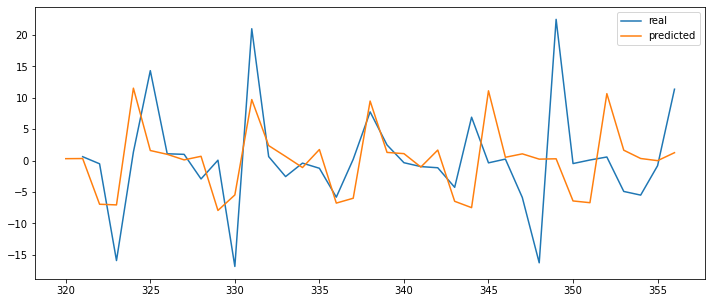

In [ ]:
test_g.plot(figsize = (12,5), label='real')
test_pred_g.plot(label = 'predicted')
plt.legend(loc='upper right')

In [ ]:
arima_rmse_error = rmse(test_g, test_pred_g[36:])
arima_mse_error = arima_rmse_error**2
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 66.97704668055086
RMSE Error: 8.183950554625245


# 1st Floor---------------------------------------------------------------------

In [ ]:
level1.sort_index(inplace= True)

In [ ]:
from scipy import stats
level1['box_cox_count'] = stats.boxcox(level1['count'])[0]

In [ ]:
train, test = train_test_split(level1['box_cox_count'].dropna(inplace=False), train_size=320)
model = pm.auto_arima(train, seasonal=True, stepwise=True)

In [ ]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  320
Model:               SARIMAX(2, 1, 5)   Log Likelihood                -413.151
Date:                Wed, 17 Nov 2021   AIC                            842.302
Time:                        21:58:18   BIC                            872.423
Sample:                             0   HQIC                           854.331
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2243      0.011    110.594      0.000       1.203       1.246
ar.L2         -0.9822      0.010    -93.950      0.000      -1.003      -0.962
ma.L1         -1.8725      0.047    -39.683      0.000      -1.965      -1.780
ma.L2          1.3717      0.101     13.636      0.000       1.175       1.569
ma.L3         -0.0203      0.119     -0.170      0.865      -0.254       0.214
ma.L4         -0.5366      0.102     -5.287      0.000      -0.736      -0.338
ma.L5          0.2122      0.049      4.292      0.000       0.115       0.309
sigma2         0.7718      0.041     18.663      0.000       0.691       0.853
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               149.79
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
pred_model = SARIMAX(train, order=(2,1,1), seasonal_order=(2,1,5,7))
results = pred_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
test_pred=test.copy()
test_pred = results.predict(start = len(train), end = len(level1)-1, typ="levels")  

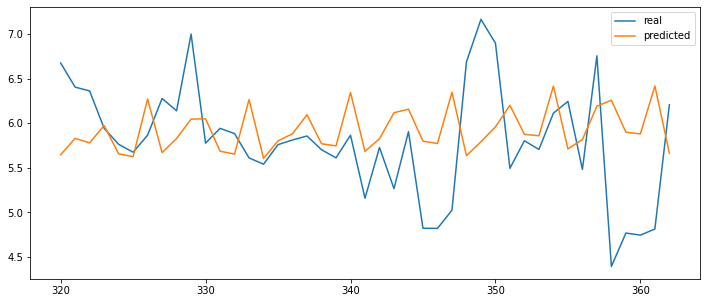

In [ ]:
test.plot(figsize = (12,5), label='real')
test_pred.plot(label = 'predicted')
plt.legend(loc='upper right')

In [ ]:
from statsmodels.tools.eval_measures import rmse
arima_rmse_error = rmse(test, test_pred[42:])
arima_mse_error = arima_rmse_error**2
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 0.4207469318677448
RMSE Error: 0.6486500843041222


# 2nd Floor --------------------------------------------------------------------------

In [ ]:
level2['box_cox_count'] = stats.boxcox(level2['count'])[0]

In [ ]:
level2['first_difference'] = level2['box_cox_count'] - level2['box_cox_count'].shift(1)   

In [ ]:
train_2, test_2 = train_test_split(level2['first_difference'].dropna(inplace=False), train_size=320)
model_2 = pm.auto_arima(train_2, seasonal=True, stepwise=True)

In [ ]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  320
Model:               SARIMAX(2, 0, 5)   Log Likelihood                -857.190
Date:                Wed, 17 Nov 2021   AIC                           1730.381
Time:                        21:58:47   BIC                           1760.527
Sample:                             0   HQIC                          1742.419
                                - 320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1629      0.022     53.418      0.000       1.120       1.206
ar.L2         -0.9608      0.020    -47.252      0.000      -1.001      -0.921
ma.L1         -1.7621      0.048    -36.963      0.000      -1.855      -1.669
ma.L2          1.2023      0.094     12.766      0.000       1.018       1.387
ma.L3          0.1127      0.105      1.072      0.284      -0.093       0.319
ma.L4         -0.6858      0.094     -7.330      0.000      -0.869      -0.502
ma.L5          0.3181      0.054      5.873      0.000       0.212       0.424
sigma2        12.3004      0.852     14.431      0.000      10.630      13.971
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                65.53
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_model_2 = SARIMAX(train_2, order=(2,1,2), seasonal_order=(2,1,5,7))
results_2 = pred_model_2.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Max

In [ ]:
test_pred_2 = test_2.copy()
test_pred_2 = results_2.predict(start = len(train_2), end = len(level2)-1, typ="levels")  

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


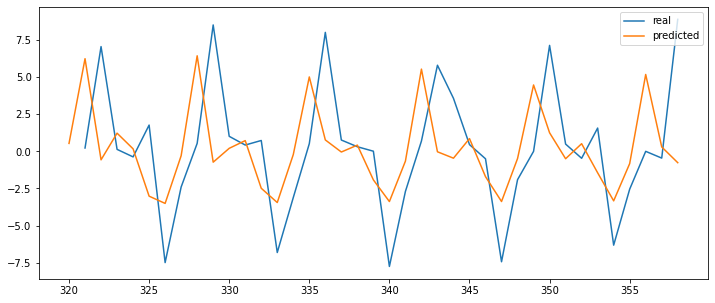

In [ ]:
test_2.plot(figsize = (12,5), label='real')
test_pred_2.plot(label = 'predicted')
plt.legend(loc='upper right')

In [ ]:
arima_rmse_error = rmse(test_2, test_pred_2[38:])
arima_mse_error = arima_rmse_error**2
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 18.355239769911467
RMSE Error: 4.284301549834169


# 3rd floor-------------------------------------------------


In [ ]:
level3['box_cox_count'] = stats.boxcox(level3['count'])[0]

In [ ]:
level3['first_difference'] = level3['box_cox_count'] - level3['box_cox_count'].shift(1)   

In [ ]:
train_3, test_3 = train_test_split(level3['first_difference'].dropna(inplace=False), train_size=260)
model_3 = pm.auto_arima(train_3, seasonal=True, stepwise=True)

In [ ]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  260
Model:               SARIMAX(4, 0, 3)   Log Likelihood                -889.086
Date:                Wed, 17 Nov 2021   AIC                           1794.171
Time:                        21:59:18   BIC                           1822.657
Sample:                             0   HQIC                          1805.623
                                - 260                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6978      0.086      8.079      0.000       0.528       0.867
ar.L2         -1.1081      0.092    -11.983      0.000      -1.289      -0.927
ar.L3          0.2725      0.072      3.776      0.000       0.131       0.414
ar.L4         -0.4746      0.069     -6.855      0.000      -0.610      -0.339
ma.L1         -1.2178      0.108    -11.304      0.000      -1.429      -1.007
ma.L2          1.0641      0.128      8.286      0.000       0.812       1.316
ma.L3         -0.4752      0.095     -4.976      0.000      -0.662      -0.288
sigma2        54.1568      4.125     13.130      0.000      46.072      62.241
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                15.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_model_3 = SARIMAX(train_3, order=(2,1,2), seasonal_order=(4,1,3,7))
results_3 = pred_model_3.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:591: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
test_pred_3 = test_3.copy()
test_pred_3 = results_3.predict(start = len(train_3), end = len(level3)-1, typ="levels")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


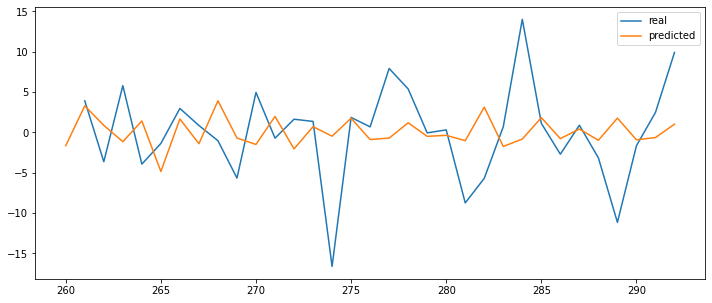

In [ ]:
test_3.plot(figsize = (12,5), label='real')
test_pred_3.plot(label = 'predicted')
plt.legend(loc='upper right')

In [ ]:
arima_rmse_error = rmse(test_3, test_pred_3[32:])
arima_mse_error = arima_rmse_error**2
print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}')

MSE Error: 34.741759904992826
RMSE Error: 5.89421410410182


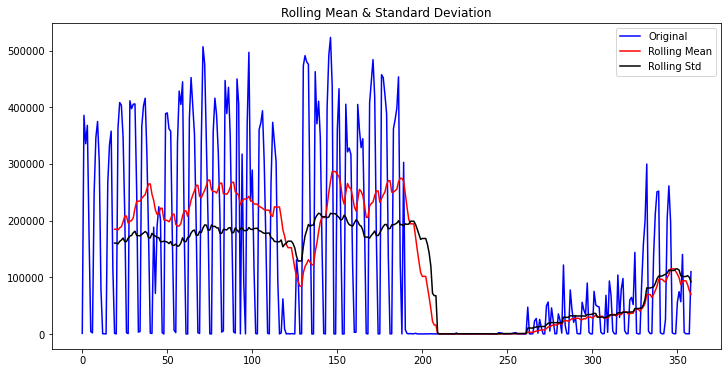

Results of Dickey-Fuller Test:
Test Statistic                  -1.535504
p-value                          0.515881
#Lags Used                      17.000000
Number of Observations Used    341.000000
Critical Value (1%)             -3.449673
Critical Value (5%)             -2.870053
Critical Value (10%)            -2.571306
dtype: float64


In [ ]:
test_stationarity(level2['count'])

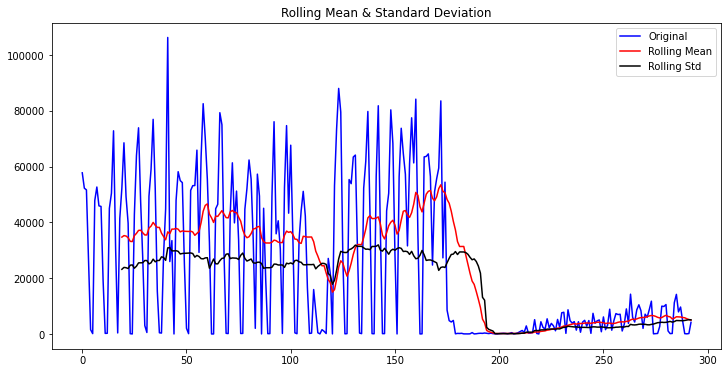

Results of Dickey-Fuller Test:
Test Statistic                  -2.437355
p-value                          0.131470
#Lags Used                       7.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [ ]:
test_stationarity(level3['count'])